In [1]:
from datasets import load_dataset
from utils import jpeg_compress, webp_compress, pad, crop, nn_compress, hific_lo_compress
import compressai
from evaluate import evaluator
from transformers import pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt

2023-10-18 15:55:18.399820: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 15:55:18.418829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 15:55:18.418845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 15:55:18.418861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 15:55:18.422780: I tensorflow/core/platform/cpu_feature_g

In [2]:
def jpeg_compress_beans(sample):
    img,bpp = jpeg_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample
    
def webp_compress_beans(sample):
    img,bpp = webp_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

net_mbt2018 = compressai.zoo.mbt2018(quality=1, pretrained=True).eval().to("cpu")
def mbt2018_compress_beans(sample):
    img,bpp = nn_compress(sample['image'],net_mbt2018,"cpu")
    sample['image'] = img
    sample['bpp'] = bpp
    return sample

def hific_lo_compress_beans(sample):
    img,bpp = hific_lo_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

In [3]:
image_compression_methods = [
    jpeg_compress_beans,
    webp_compress_beans,
    mbt2018_compress_beans,
    hific_lo_compress_beans
]
models = [
    "nateraw/vit-base-beans"
]

In [4]:
beans = [load_dataset("beans", split="validation")]

In [5]:
for method in image_compression_methods:
    beans.append(beans[0].map(method))

In [6]:
pipe = []
for model in models:
    pipe.append(
        pipeline(
            task="image-classification",
            model=model,
            device="cuda:0"
        )
    )

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [7]:
task_evaluator = evaluator("image-classification")

In [8]:
eval_results = []
for i_method,method in enumerate(beans):
    eval_results.append([])
    for i_model,model in enumerate(pipe):
        eval_results[i_method].append(
            task_evaluator.compute(
                model_or_pipeline=model,
                data=method,
                label_column='labels',
                metric="accuracy",
                label_mapping=model.model.config.label2id
            )
        )

In [9]:
classification_acc = np.array(
    [[rij['accuracy'] for rij in r] for r in eval_results]
)
classification_acc

array([[0.97744361],
       [0.76691729],
       [0.95488722],
       [0.94736842],
       [0.98496241]])

In [10]:
baseline_acc = classification_acc[0]
classification_acc = classification_acc[1:]

In [11]:
image_bpp = [np.mean(method['bpp']) for method in beans[1:]]
image_bpp

[0.24133606015037593,
 0.14150833082706765,
 0.14844727819548872,
 0.028631127819548872]

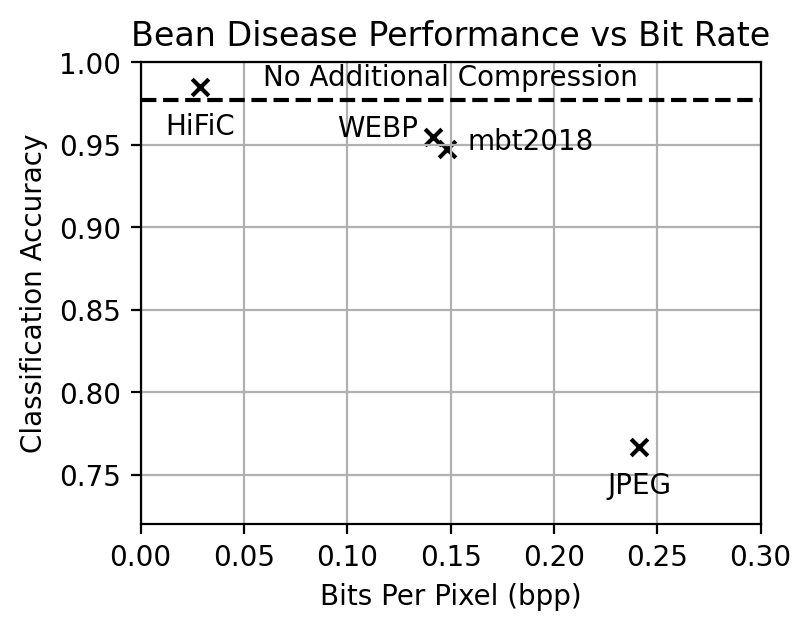

In [25]:
image_compression_names = [
    'JPEG',
    'WEBP',
    'mbt2018',
    'HiFiC'
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, classification_acc, c='black', marker='x')
plt.annotate("No Additional Compression", (0.15, baseline_acc), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[baseline_acc,baseline_acc],'--',c='black')
for i, name in enumerate(image_compression_names):
    if i==1:
        offset = (-20,0)
    elif i==2:
        offset = (30,0)
    else:
        offset = (0,-17)
    plt.annotate(name, (image_bpp[i], classification_acc[i]), textcoords="offset points", xytext=offset, ha='center')

plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Classification Accuracy')
plt.title('Bean Disease Performance vs Bit Rate')
plt.xlim([0,0.3])
plt.ylim([0.72,1.0])
plt.grid(True)
plt.show()

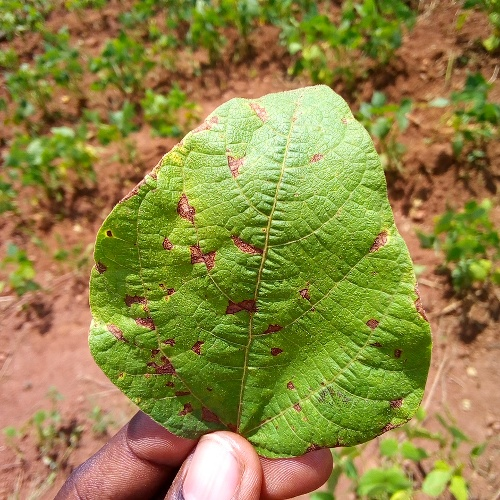

In [16]:
beans[0][0]['image']

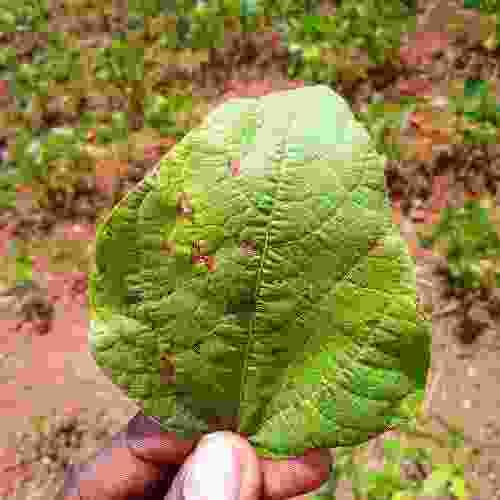

In [17]:
beans[1][0]['image']

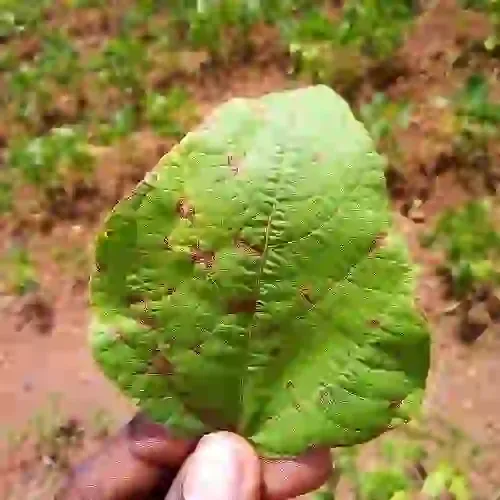

In [18]:
beans[2][0]['image']

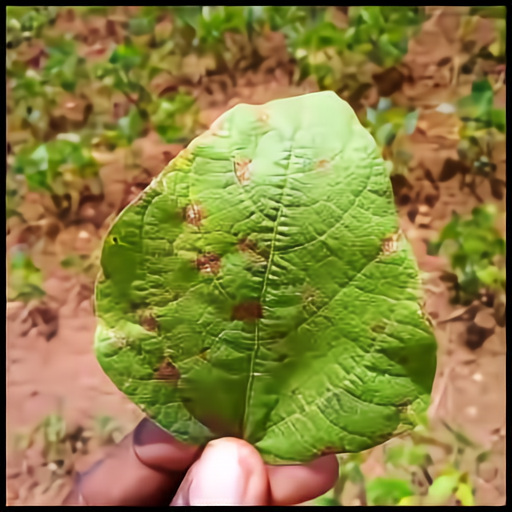

In [19]:
beans[3][0]['image']

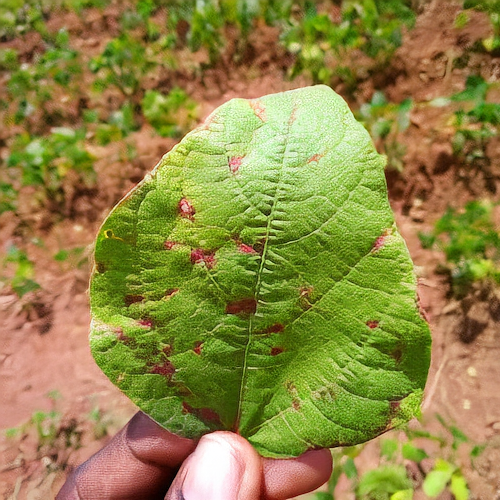

In [20]:
beans[4][0]['image']